In [25]:
import importlib, os, gc, sys
import SXBQ as sx
import WMT_functions as wmt

from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import fsolve, fmin
from scipy.signal import convolve as conv
import gsw
import cmocean.cm as cmo
from datetime import datetime as dt
import matplotlib.dates as mdates
import math

import matplotlib.colors as cl
from gsw import z_from_p, p_from_z, distance, SA_from_SP, CT_from_t, rho, distance, cp_t_exact


from scipy.signal import find_peaks
from scipy.stats import linregress


from matplotlib.gridspec import GridSpec

import glidertools as gt
import matplotlib.colors as colors
import matplotlib.cm as cm

from matplotlib.colors import ListedColormap
from matplotlib.gridspec import GridSpec

import seaborn as sns
sns.set(    rc={
         'axes.axisbelow': False,
         'axes.edgecolor': 'Black',
         'axes.facecolor': 'white',
         'axes.grid': False,
         'axes.labelcolor': 'dimgray',
            
         'axes.spines.right': True,
         'axes.spines.top': True,
         'figure.facecolor': 'white',
         'lines.solid_capstyle': 'round',
         'patch.edgecolor': 'k',
         'patch.force_edgecolor': True,
         'text.color': 'dimgray',
         'xtick.bottom': True,
         'xtick.color': 'dimgray',
         'xtick.direction': 'out',
         'xtick.top': False,
         'ytick.color': 'dimgray',
         'ytick.direction': 'out',
         'ytick.left': True,
         'ytick.right': False},
         font_scale=1.6)

import warnings
warnings.filterwarnings('ignore')

def interp(x,y,xi):
    _gg = np.isfinite(x+y)
    return interp1d(x[_gg], y[_gg], bounds_error=False, fill_value=np.NaN)(xi)

## Load data

In [26]:
ds=xr.open_dataset('/home/jupyter-estelfont/datasets/argo/ModeWater_SoO/gridded_along_across_SoO_per_month.nc')

ds['PV_along']=ds.abs_salinity_along.copy()*np.nan
ds['density_in_situ_along']=gsw.rho(ds.abs_salinity_along, ds.cons_temp_along, ds.pressure)
f_param=gsw.f(np.nanmean(24.4))
ds['PV_along'][:, :, :-1]=(f_param/ds['density_in_situ_along'].values[:, :, :-1])*(np.diff(ds.sigma_along.values, axis=2)/1)


ds['PV_across']=ds.abs_salinity_along.copy()*np.nan
ds['density_in_situ_across']=gsw.rho(ds.abs_salinity_across, ds.cons_temp_across, ds.pressure)
f_param=gsw.f(np.nanmean(24.4))
ds['PV_across'][:, :, :-1]=(f_param/ds['density_in_situ_across'].values[:, :, :-1])*(np.diff(ds.sigma_across.values, axis=2)/1)
    
ds_climat=ds.copy()


## GRIDDING AND CONFIG

In [13]:
# S_var='abs_salinity'  # or 'spice'
# T_var='cons_temp'   # or 'potential_density'
# dS = 0.03   #0.2
# dT = 0.3    # 0.1 
# S_range = (35, 38)  # (1, 9)
# T_range = (10, 32)  # (22, 28)


S_var='spice'  # or 'spice'
T_var='sigma'   # or 'potential_density'
dS = 0.1   #0.2
dT = 0.05   # 0.1 
S_range = (1, 9)
T_range =  (22, 28)


dataset='climat'

if dataset=='climat':
    dx, dy=3, 2
    across='across'
    open_or_close='open'
    saa=S_var+'_'+across
    ctt=T_var+'_'+across
    if across=='along':
            ds_cl=ds_climat.sel(distance=slice(200,500))
    if across=='across':
            ds_cl=ds_climat.copy()
            
    month_i,month_f=3,6

## Section plots

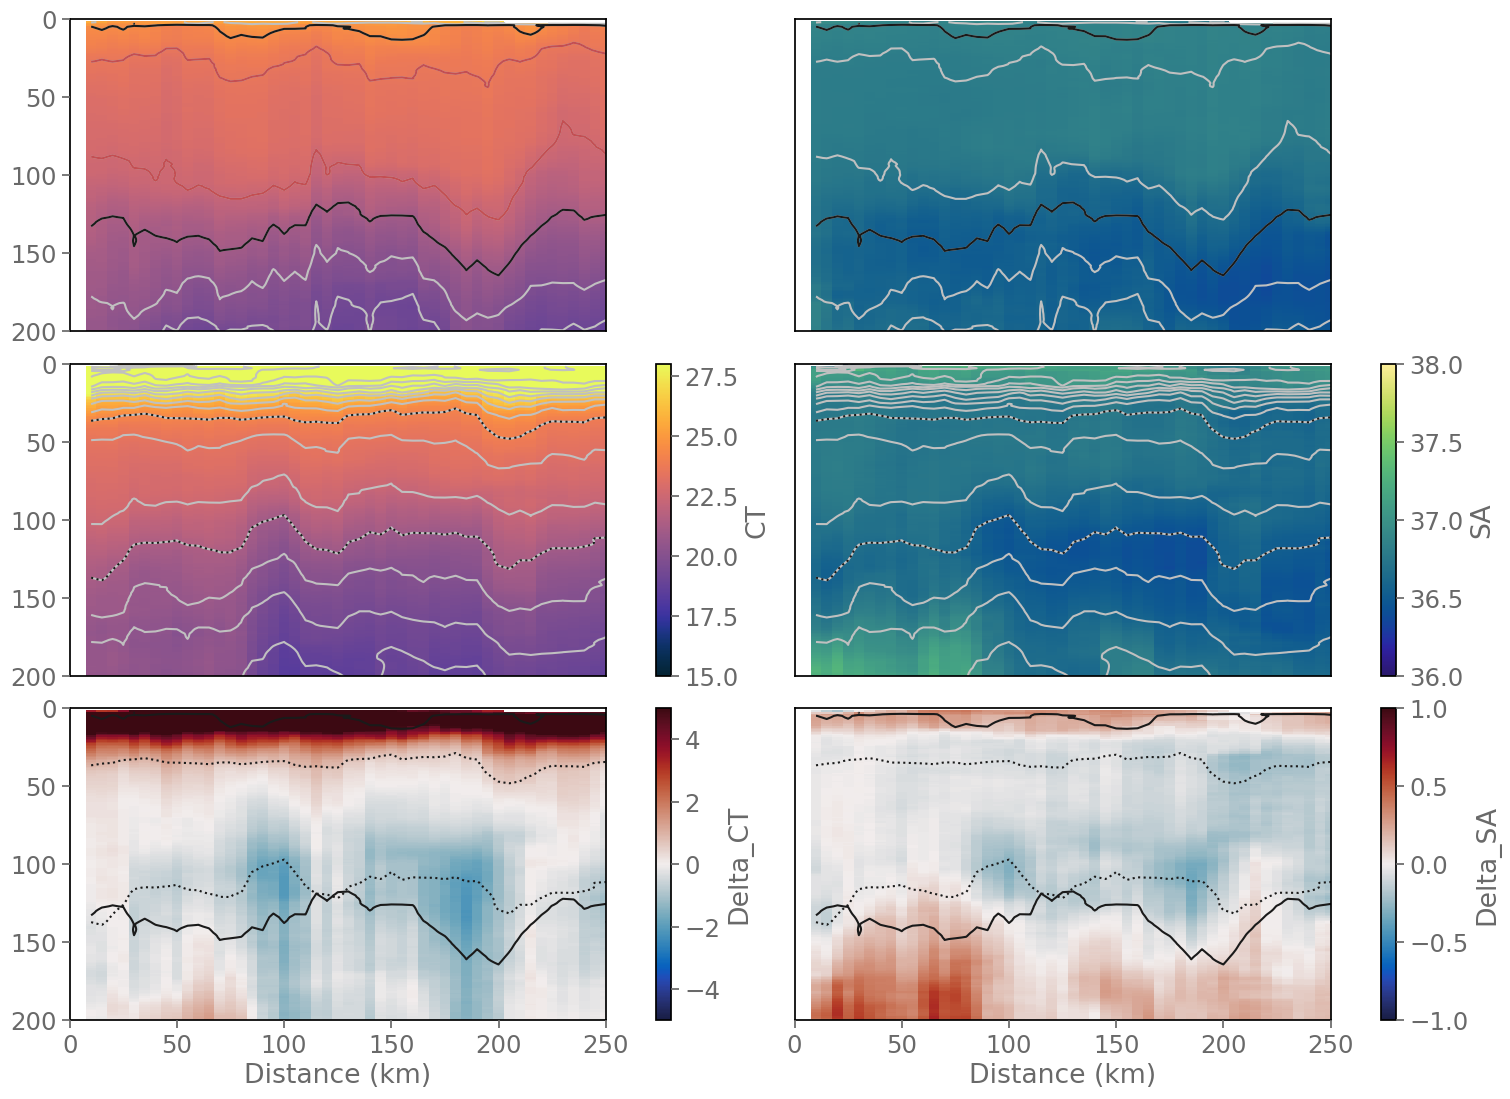

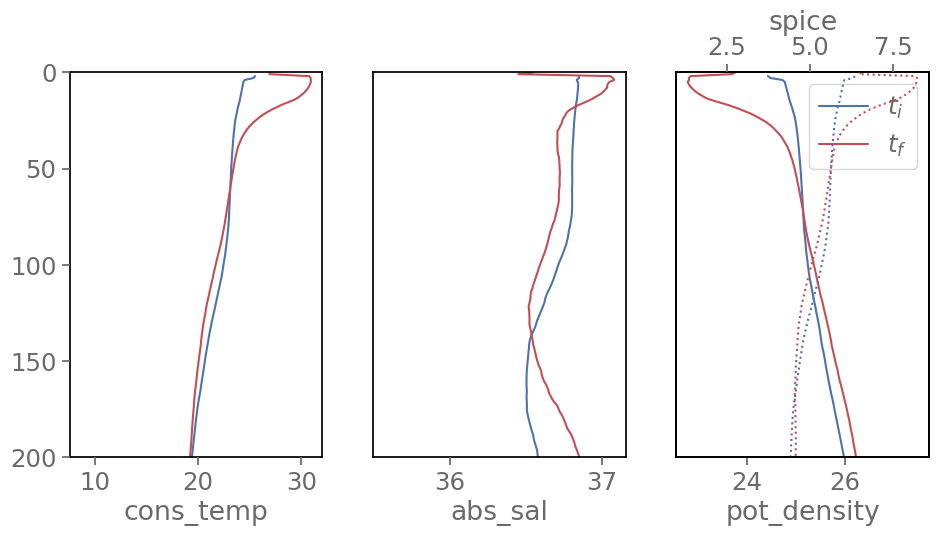

In [9]:
plt.figure(figsize=(15,14), constrained_layout=True)

if dataset=='climat':
    xaxis=ds_cl.distance
    yaxis=ds_cl.pressure
    if across=='along':
        ds_cl=ds_cl.sel(distance=slice(200,500))
    ct1=ds_cl['cons_temp_'+across].sel(month=month_i).T
    ct2=ds_cl['cons_temp_'+across].sel(month=month_f).T
    sa1=ds_cl['abs_salinity_'+across].sel(month=month_i).T
    sa2=ds_cl['abs_salinity_'+across].sel(month=month_f).T
    sig1=ds_cl['sigma_'+across].sel(month=month_i).T
    sig2=ds_cl['sigma_'+across].sel(month=month_f).T
    spice1=ds_cl['spice_'+across].sel(month=month_i).T
    spice2=ds_cl['spice_'+across].sel(month=month_f).T
    xaxis=ct1.distance.values
    yaxis=ct1.pressure.values
    if across=='across':
        xmin, xmax=0,250
    else:
        xmin, xmax=0,500
        
    ################ sections


ax1=plt.subplot(421)
plt.pcolormesh(xaxis, yaxis, ct1, vmin=15, vmax=28, cmap=cmo.thermal)
plt.contour(xaxis, yaxis, sig1, levels=np.arange(22,28,0.25), colors='silver')
plt.contour(xaxis, yaxis, sig1, levels=[24.75, 25.5], colors='k')
plt.contour(xaxis, yaxis, sig1, levels=[25, 25.25], colors='r')

# plt.contour(xaxis, yaxis, spice1, levels=np.arange(1,9,0.5), colors='red', alpha=0.3)
# plt.contour(xaxis, yaxis, spice1, levels=[5.5,6], colors='red')

ax2=plt.subplot(422)
plt.pcolormesh(xaxis, yaxis, sa1, vmin=36, vmax=38, cmap=cmo.haline)
plt.contour(xaxis, yaxis, sig1, levels=np.arange(22,28,0.25), colors='silver')
plt.contour(xaxis, yaxis, sig1, levels=[24.75, 25.5], colors='k')
# plt.contour(xaxis, yaxis, spice1, levels=np.arange(1,9,0.5), colors='red', alpha=0.3)
# plt.contour(xaxis, yaxis, spice1, levels=[5.5,6], colors='red')

ax3=plt.subplot(423)
plt.pcolormesh(xaxis, yaxis, ct2, vmin=15, vmax=28, cmap=cmo.thermal)
cb=plt.colorbar()
cb.set_label('CT')
plt.contour(xaxis, yaxis, sig2, levels=np.arange(22,28,0.25), colors='silver')
plt.contour(xaxis, yaxis, sig2, levels=[24.75, 25.5], colors='k', linestyles=':')
# plt.contour(xaxis, yaxis, spice2, levels=np.arange(1,9,0.5), colors='red', alpha=0.3)
# plt.contour(xaxis, yaxis, spice2, levels=[5.5,6], colors='red', linestyles=':')

ax4=plt.subplot(424)
plt.pcolormesh(xaxis, yaxis, sa2, vmin=36, vmax=38, cmap=cmo.haline)
cb=plt.colorbar()
cb.set_label('SA')

plt.contour(xaxis, yaxis, sig2, levels=np.arange(22,28,0.25), colors='silver')
plt.contour(xaxis, yaxis, sig2, levels=[24.75, 25.5], colors='k', linestyles=':')
# plt.contour(xaxis, yaxis, spice2, levels=np.arange(1,9,0.5), colors='red', alpha=0.3)
# plt.contour(xaxis, yaxis, spice2, levels=[5.5,6], colors='red', linestyles=':')

ax5=plt.subplot(425)
plt.pcolormesh(xaxis, yaxis, ct2-ct1, vmin=-5, vmax=5, cmap=cmo.balance)
cb=plt.colorbar()
cb.set_label('Delta_CT')

plt.contour(xaxis, yaxis, sig1, levels=[24.75, 25.5], colors='k')
plt.contour(xaxis, yaxis, sig2, levels=[24.75, 25.5], colors='k', linestyles=':')
# plt.contour(xaxis, yaxis, spice1, levels=[5.5,6], colors='red')
# plt.contour(xaxis, yaxis, spice2, levels=[5.5,6], colors='red', linestyles=':')
plt.xlabel('Distance (km)')


ax6=plt.subplot(426)
plt.pcolormesh(xaxis, yaxis, sa2-sa1 , vmin=-1, vmax=1, cmap=cmo.balance)
cb=plt.colorbar()
cb.set_label('Delta_SA')

plt.contour(xaxis, yaxis, sig1, levels=[24.75, 25.5], colors='k')
plt.contour(xaxis, yaxis, sig2, levels=[24.75, 25.5], colors='k', linestyles=':')
# plt.contour(xaxis, yaxis, spice1, levels=[5.5,6], colors='red')
# plt.contour(xaxis, yaxis, spice2, levels=[5.5,6], colors='red', linestyles=':')
plt.xlabel('Distance (km)')

for az in [ax1,ax2,ax3,ax4]:
    az.set_xticks([])
    
for az in [ax1,ax2,ax3,ax4,ax5,ax6]:
    az.set_ylim(200,0)
    az.set_xlim(xmin, xmax)
for az in [ax2,ax4,ax6]:
    az.set_yticks([])

    
################ profiles

plt.figure(figsize=(15,5))
plt.subplot(141)
plt.plot(np.nanmean(ct1,axis=1), yaxis)
plt.plot(np.nanmean(ct2,axis=1), yaxis, c='r')
plt.ylim(200,0)
plt.xlabel('cons_temp')

plt.subplot(142)
plt.plot(np.nanmean(sa1,axis=1), yaxis)
plt.plot(np.nanmean(sa2,axis=1), yaxis, c='r')
plt.ylim(200,0)
plt.xlabel('abs_sal')

plt.yticks([])


plt.subplot(143)

plt.plot(np.nanmean(sig1,axis=1), yaxis,label='$t_i$')
plt.plot(np.nanmean(sig2,axis=1), yaxis, c='r', label='$t_f$')
plt.ylim(200,0)
plt.xlabel('pot_density')

plt.yticks([])
plt.legend()

plt.twiny()
plt.plot(np.nanmean(spice1,axis=1), yaxis,ls=':')
plt.plot(np.nanmean(spice2,axis=1), yaxis, c='r',ls=':')
plt.xlabel('spice')


if dataset=='glider':
    if climat_or_transect=='transect':

        plt.figure(figsize=(15,3))
        plt.scatter(ds_79mw.time, ds_79mw.distance_pp_colocated_on_transect.mean('pressure'), c='k', alpha=0.3)
        # plt.scatter(ds_79mw.time, ds_79mw.lat_pp.mean('pressure'), c=ds_79mw.transect_num.mean('pressure'), cmap=plt.get_cmap(cmo.matter, 25), vmin=1, vmax=25, alpha=0.3)
        # plt.colorbar()
        plt.scatter(ds2_.sel(transect_number=month_i).time, ds2_.sel(transect_number=month_i).distance_pp_colocated_on_transect.mean('pressure'), c='blue')
        plt.scatter(ds2_.sel(transect_number=month_f).time, ds2_.sel(transect_number=month_f).distance_pp_colocated_on_transect.mean('pressure'), c='red')

        plt.ylim(0,100)
        plt.axhline(20, c='gray')
        plt.axhline(70, c='gray')




    elif climat_or_transect=='month':

        plt.figure(figsize=(15,3))
        plt.scatter(ds_79mw.time, ds_79mw.distance_pp_colocated_on_transect.mean('pressure'), c='k', alpha=0.3)
        plt.scatter(ds_79mw.time.sel(time=slice('2015-0'+str(month_i), '2015-0'+str(month_i))), ds_79mw.distance_pp_colocated_on_transect.mean('pressure').sel(time=slice('2015-0'+str(month_i), '2015-0'+str(month_i))), c='blue')
        plt.scatter(ds_79mw.time.sel(time=slice('2015-0'+str(month_f), '2015-0'+str(month_f))), ds_79mw.distance_pp_colocated_on_transect.mean('pressure').sel(time=slice('2015-0'+str(month_f), '2015-0'+str(month_f))), c='red')
        plt.ylim(0,100)
        plt.axhline(20, c='gray')
        plt.axhline(70, c='gray')
        plt.ylabel('Distance (km)')


# TRANSFORMATION APRIL TO JUNE

In [14]:
for month_i in tqdm(range(4,5)):  ##month_i is transect number actually...
    month_f=month_i+3
    dt=(month_f-month_i)*30*24*60*60
    
    # t_arr=pd.to_datetime(np.array(['2015-'+[f"0{month_i}" if month_i < 10 else f"{month_i}"][0]+'-01', '2015-'+[f"0{month_i}" if month_i < 10 else f"{month_i}"][0]+'-15', '2015-'+[f"0{month_f}" if month_f < 10 else f"{month_f}"][0]+'-01']))
    t_arr=pd.to_datetime(np.array(['2015-'+[f"0{month_i}" if month_i < 10 else f"{month_i}"][0]+'-01', '2015-'+[f"0{month_i+1}" if (month_i+1) < 10 else f"{month_i+1}"][0]+'-01', '2015-'+[f"0{month_f}" if month_f < 10 else f"{month_f}"][0]+'-01']))
    
    salinity_noflat=[ds_cl.sel(month=month_i)[saa].T.values, ds_cl.sel(month=month_i+1)[saa].T.values, ds_cl.sel(month=month_f)[saa].T.values]
    temperature_noflat=[ds_cl.sel(month=month_i)[ctt].T.values, ds_cl.sel(month=month_i+1)[ctt].T.values, ds_cl.sel(month=month_f)[ctt].T.values]
    
    salinity=[ds_cl.sel(month=month_i)[saa].values.T.flatten(), ds_cl.sel(month=month_i+1)[saa].T.values.flatten(), 
              ds_cl.sel(month=month_f)[saa].T.values.flatten()]
    temperature=[ds_cl.sel(month=month_i)[ctt].values.T.flatten(), ds_cl.sel(month=month_i+1)[ctt].T.values.flatten(),
                 ds_cl.sel(month=month_f)[ctt].T.values.flatten()]

    salinity_surf=[np.nanmean(ds_cl.sel(month=month_i)[saa].values.T[:5, :] , axis=0), np.nanmean(ds_cl.sel(month=month_i+1)[saa].values.T[:5, :] , axis=0), 
                   np.nanmean(ds_cl.sel(month=month_f)[saa].values.T[:5, :] , axis=0)]
    temperature_surf=[np.nanmean(ds_cl.sel(month=month_i)[ctt].values.T[:5, :] , axis=0), np.nanmean(ds_cl.sel(month=month_i+1)[ctt].values.T[:5, :] , axis=0), 
                      np.nanmean(ds_cl.sel(month=month_f)[ctt].values.T[:5, :] , axis=0)]

    print(month_f-month_i)
   

    ## compute transformation      
    ts_trans = wmt.mk_ts_trans_ds(dS, dT, S_range, T_range, t_arr)
    #cal area
    ts_trans = wmt.calc_ts_area(salinity, temperature,salinity_noflat,temperature_noflat,   ts_trans, dx, dy, open_or_close).fillna(0)
    # calc transformation
    ts_trans = wmt.ts_trans_cdiff(ts_trans,  dt)


    ts_trans['dvol_G']=ts_trans.dvol_G.where(ts_trans.dvol_G!=0)
    ts_trans['G_s']=ts_trans.G_s.where(ts_trans.G_s!=0)
    ts_trans['G_t']=ts_trans.G_t.where(ts_trans.G_t!=0)

    ts_trans['epsilon']=ts_trans.epsilon.where(ts_trans.epsilon!=0)
    
#     ts_trans['dvol_F'] = ts_trans.dvol_G.fillna(0) - ts_trans.epsilon.fillna(0)
#     ts_trans['dvol_F'] = ts_trans.dvol_F.where(~np.isnan(ts_trans['dvol_F']), 0)

#     ts_trans = wmt.calc_osanp_F(ts_trans, dt)
        
    # if month_i==3:
    if month_i==4:
        ts_trans_all=ts_trans.copy()
    elif month_i>4:
        ts_trans_all=xr.merge([ts_trans_all, ts_trans])


ts_trans_all['G_si']=ts_trans_all.G_si.where(ts_trans_all.G_si!=0, np.nan)
ts_trans_all['G_ti']=ts_trans_all.G_ti.where(ts_trans_all.G_ti!=0, np.nan)

  0%|          | 0/1 [00:00<?, ?it/s]

3


In [21]:
# ts_trans_all.to_netcdf('ArgoAPRILJULY_WMT_TS.nc')
# ts_trans_all.to_netcdf('ArgoAPRILJULY_WMT_sigma_spice.nc')

# MONTHLY TRANSFOMRAITON

In [18]:
for month_i in tqdm(range(3,10)):  ##month_i is transect number actually...
    month_f=month_i+1
    dt=(month_f-month_i)*30*24*60*60
    t_arr=pd.to_datetime(np.array(['2015-'+[f"0{month_i}" if month_i < 10 else f"{month_i}"][0]+'-01', '2015-'+[f"0{month_i}" if (month_i) < 10 else f"{month_i+1}"][0]+'-15', '2015-'+[f"0{month_f}" if month_f < 10 else f"{month_f}"][0]+'-01']))
    
    salinity_noflat=[ds_cl.sel(month=month_i)[saa].T.values, ds_cl.sel(month=month_i+1)[saa].T.values, ds_cl.sel(month=month_f)[saa].T.values]
    temperature_noflat=[ds_cl.sel(month=month_i)[ctt].T.values, ds_cl.sel(month=month_i+1)[ctt].T.values, ds_cl.sel(month=month_f)[ctt].T.values]
    
    salinity=[ds_cl.sel(month=month_i)[saa].values.T.flatten(), ds_cl.sel(month=month_i+1)[saa].T.values.flatten(), 
              ds_cl.sel(month=month_f)[saa].T.values.flatten()]
    temperature=[ds_cl.sel(month=month_i)[ctt].values.T.flatten(), ds_cl.sel(month=month_i+1)[ctt].T.values.flatten(),
                 ds_cl.sel(month=month_f)[ctt].T.values.flatten()]

    salinity_surf=[np.nanmean(ds_cl.sel(month=month_i)[saa].values.T[:5, :] , axis=0), np.nanmean(ds_cl.sel(month=month_i+1)[saa].values.T[:5, :] , axis=0), 
                   np.nanmean(ds_cl.sel(month=month_f)[saa].values.T[:5, :] , axis=0)]
    temperature_surf=[np.nanmean(ds_cl.sel(month=month_i)[ctt].values.T[:5, :] , axis=0), np.nanmean(ds_cl.sel(month=month_i+1)[ctt].values.T[:5, :] , axis=0), 
                      np.nanmean(ds_cl.sel(month=month_f)[ctt].values.T[:5, :] , axis=0)]

    print(month_f-month_i)
   

    ## compute transformation      
    ts_trans = wmt.mk_ts_trans_ds(dS, dT, S_range, T_range, t_arr)
    #cal area
    ts_trans = wmt.calc_ts_area(salinity, temperature,salinity_noflat,temperature_noflat,   ts_trans, dx, dy, open_or_close).fillna(0)
    # calc transformation
    ts_trans = wmt.ts_trans_cdiff(ts_trans,  dt)


    ts_trans['dvol_G']=ts_trans.dvol_G.where(ts_trans.dvol_G!=0)
    ts_trans['G_s']=ts_trans.G_s.where(ts_trans.G_s!=0)
    ts_trans['G_t']=ts_trans.G_t.where(ts_trans.G_t!=0)

    ts_trans['epsilon']=ts_trans.epsilon.where(ts_trans.epsilon!=0)
    
    if month_i==3:
        ts_trans_all=ts_trans.copy()
    elif month_i>3:
        ts_trans_all=xr.merge([ts_trans_all, ts_trans])



ts_trans_all['G_si']=ts_trans_all.G_si.where(ts_trans_all.G_si!=0, np.nan)
ts_trans_all['G_ti']=ts_trans_all.G_ti.where(ts_trans_all.G_ti!=0, np.nan)

  0%|          | 0/7 [00:00<?, ?it/s]

1
1
1
1
1
1
1


In [16]:
ts_trans_all.to_netcdf('Argo_bymonth_WMT_01_0.05.nc')

#### Extra plots to check!

In [22]:
ts_trans_all_MW=ts_trans_all.sel(T_bin=slice(24.75, 25.5), S_bin=slice(4, 6.5+dS),T_bini=slice(24.75, 25.5), S_bini=slice(4, 6.5+dS), T_binii=slice(24.75, 25.5+dT), S_binii=slice(4, 6.5+dS))


def sigmspice_ax_big(ax):
    # limto=4
    mins,maxs=35, 39
    mint,maxt=12,35

    tempL,salL=np.linspace(mint,maxt,1000), np.linspace(mins,maxs,1000)
    Wg, Qg = np.meshgrid(tempL,salL)
    
    sig = gsw.sigma0(Qg, Wg)
    spice = gsw.spiciness0(Qg, Wg)
    
    CS=ax.contour(spice, sig, Wg, colors='silver', linestyles='dashed', linewidths=1, levels=np.arange(5,32,2))
    ax.clabel(CS, inline=1, fontsize=12)
    # CS=ax.contour(Qg, Wg, sig, colors='k', linestyles='dashed', linewidths=1, levels=[25, 25.25])
    # ax.clabel(CS, inline=1, fontsize=12)

    CS=ax.contour(spice, sig, Qg, colors='green', linestyles='dashed', linewidths=1, levels=np.arange(30,40,1), alpha=0.5)
    ax.clabel(CS, inline=1, fontsize=12,fmt='%0.1f')
    return

def sigmspice_ax(ax):
    # limto=4
    mins,maxs=36.5, 37.2
    mint,maxt=22,25

    tempL,salL=np.linspace(mint,maxt,1000), np.linspace(mins,maxs,1000)
    Wg, Qg = np.meshgrid(tempL,salL)
    
    sig = gsw.sigma0(Qg, Wg)
    spice = gsw.spiciness0(Qg, Wg)
    
    CS=ax.contour(spice, sig, Wg, colors='silver', linestyles='dashed', linewidths=1, levels=np.arange(5,32,0.5))
    ax.clabel(CS, inline=1, fontsize=12)
    # CS=ax.contour(Qg, Wg, sig, colors='k', linestyles='dashed', linewidths=1, levels=[25, 25.25])
    # ax.clabel(CS, inline=1, fontsize=12)

    CS=ax.contour(spice, sig, Qg, colors='green', linestyles='dashed', linewidths=1, levels=np.arange(30,40,0.1), alpha=0.5)
    ax.clabel(CS, inline=1, fontsize=12,fmt='%0.1f')
    return


##gsw_SA_CT_from_sigma0_spiciness0


def plt_box(ax, x1,x2,y1,y2): #36.5,37.2, 22,25
    ax.plot([x1,x2], [y1,y1], c='k')
    ax.plot([x1,x2], [y2,y2], c='k')
    ax.plot([x1,x1], [y1,y2], c='k')
    ax.plot([x2, x2], [y1,y2], c='k')

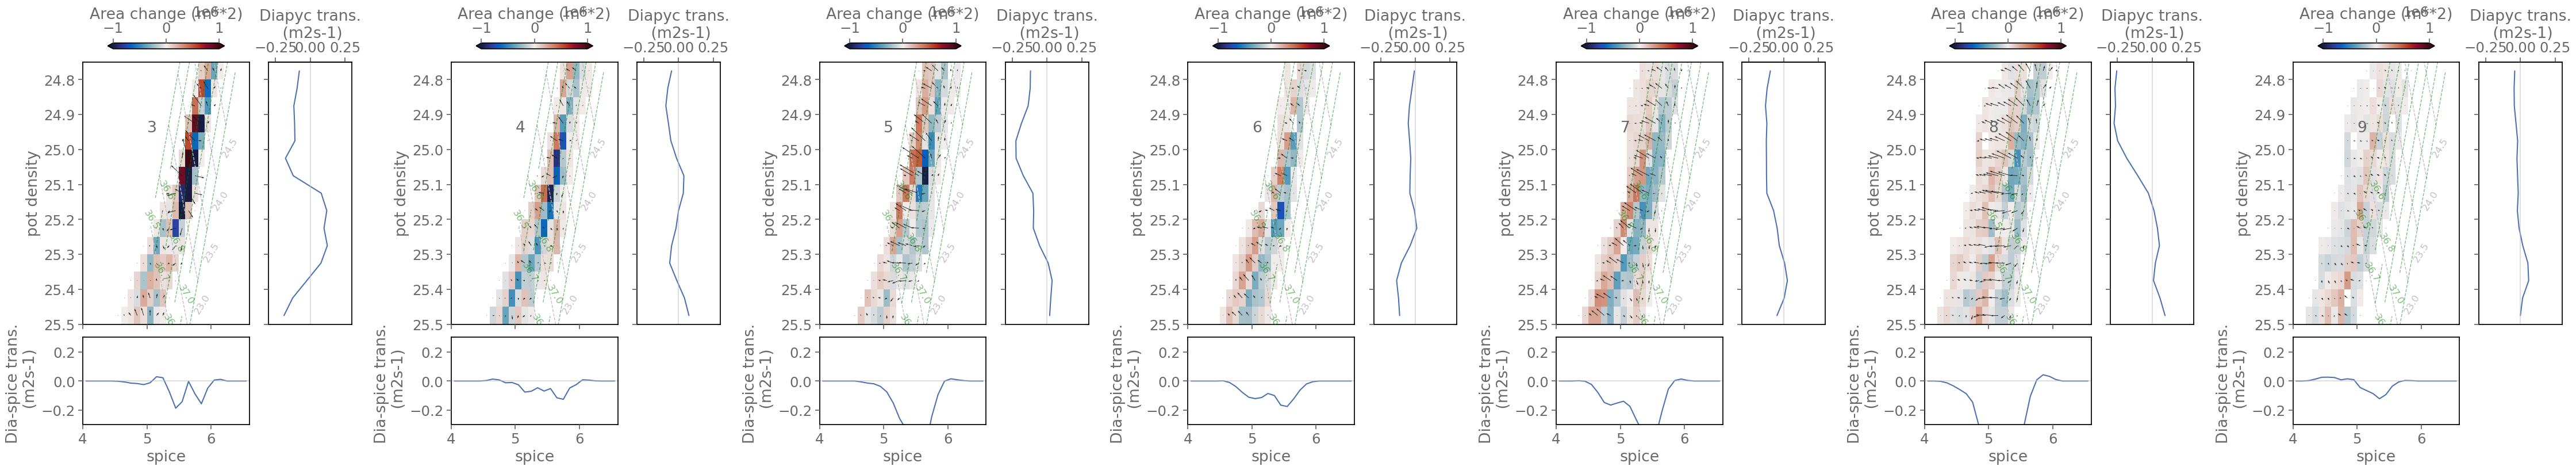

In [23]:
ff = plt.figure(constrained_layout=True, figsize=(55, 8))
spec2 = GridSpec(ncols=4*len(ts_trans_all.time_mid), nrows=4, figure=ff)


for i in range(len(ts_trans_all.time_mid)):
    ts_trans=ts_trans_all_MW.isel(time_mid=i)
    
    ax1 = ff.add_subplot(spec2[0:3, 3*(i):3*(i)+2])

    plt.ylabel('pot density')
    sigmspice_ax(ax1)

    plt.pcolormesh(ts_trans.S_bini, ts_trans.T_bini, ts_trans.dvol_G, vmin=-1000000, vmax=1000000, cmap=cmo.balance)

    cb=plt.colorbar(orientation='horizontal', pad=-1.23, shrink=0.7, extend='both')
    cb.ax.xaxis.set_ticks_position('top')
    plt.text(5,24.95, s=str(i+3))
    plt.quiver(ts_trans.S_bini, ts_trans.T_bini, ts_trans.G_si, -ts_trans.G_ti, scale=1)
    cb.set_label('Area change (m**2)')
    cb.ax.xaxis.set_label_position('top')
    plt.gca().tick_params(axis='x', which='both', labelbottom=False)
    plt.ylim(25.5, 24.75)
    # plt.ylim(25.3, 24.9)
    plt.xlim(4, 6.5+dS)
    # plt.axhline(25, c='k')
    # plt.axhline(25.2, c='k')

    ax2 = ff.add_subplot(spec2[3,3*(i):3*(i)+2])
    plt.plot(ts_trans.S_bini,  ts_trans.G_si.sum(dim='T_bini'))
    plt.ylim(-0.3, 0.3)
    # plt.xlim(35.5,38)
    plt.axhline(0,c='silver', alpha=0.5)
    plt.ylabel('Dia-spice trans. \n (m2s-1)')
    # plt.xlim(4.7, 6.3)
    plt.xlabel('spice')
    plt.xlim(4, 6.5+dS)

    ax3 = ff.add_subplot(spec2[:3, 3*(i)+2])
    plt.plot( ts_trans.G_ti.sum(dim='S_bini'), ts_trans.T_bini)
    plt.gca().tick_params(axis='y', which='both', labelleft=False)
    ax3.tick_params(axis='x', bottom=False, labelbottom=False)

    ax_top = ax3.secondary_xaxis('top')
    ax_top.set_xlabel('Diapyc trans.\n (m2s-1)')

    # plt.ylim(10,32)
    plt.xlim(-0.3, 0.3)
    plt.axvline(0,c='silver', alpha=0.5)
    plt.ylim(25.5, 24.75)
    
    # plt.gca().invert_yaxis()

In [123]:
# plt.pcolormesh(ts_trans.S_bini, ts_trans.T_bini, ts_trans.epsilon/dt, vmin=-vminmax, vmax=vminmax, cmap=cmo.balance)


[]

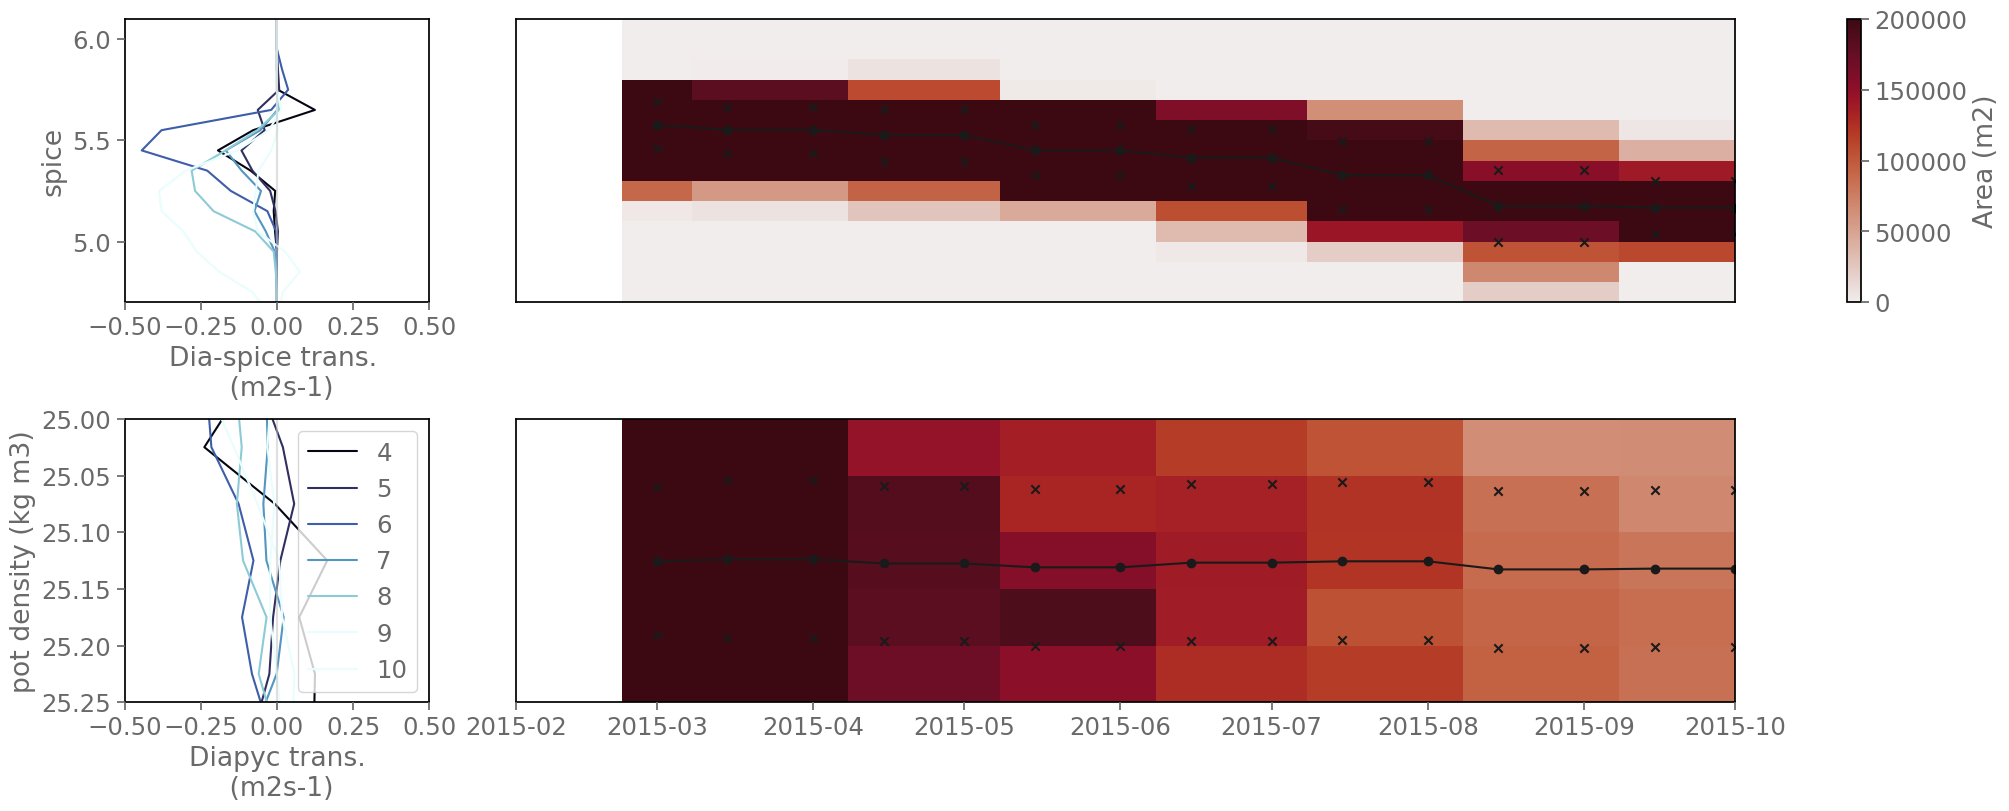

In [15]:
# colors_

sigmamin_, sigmamax_ = 25, 25.25
spicemin_, spicemax_ =4.7,6.1


ff = plt.figure(constrained_layout=True, figsize=(20, 8))
spec2 = GridSpec(ncols=5, nrows=2, figure=ff)

colors_=plt.get_cmap('cmo.ice', 6)

ax1 = ff.add_subplot(spec2[0, 0])
ax2 = ff.add_subplot(spec2[1, 0])
for i in range(len(ts_trans_all.time_mid)):

    ts_trans=ts_trans_all.isel(time_mid=i)
    # spec2 = GridSpec(ncols=8, nrows=4, figure=ff)
    ax1.plot(  ts_trans.G_s.sel(T_bini=slice(sigmamin_, sigmamax_)).sum(dim='T_bini'), ts_trans.S_bini[:-1], c=colors_(i))
    ax2.plot( ts_trans.G_t.sel(S_bini=slice(spicemin_, spicemax_)).sum(dim='S_bini') , ts_trans.T_bini[:-1], c=colors_(i), label=str(i+4))

ax1.set_xlim(-0.5, 0.5)
ax1.axvline(0,c='silver', alpha=0.5)
ax1.set_xlabel('Dia-spice trans. \n (m2s-1)')
ax1.set_ylim(spicemin_, spicemax_)
ax1.set_ylabel('spice')

ax2.set_xlabel('Diapyc trans.\n (m2s-1)')
ax2.set_xlim(-0.5, 0.5)
ax2.axvline(0,c='silver', alpha=0.5)
ax2.set_ylim(sigmamax_, sigmamin_)
ax2.set_ylabel('pot density (kg m3)')
plt.legend()


ax1 = ff.add_subplot(spec2[0, 1:])
ax2 = ff.add_subplot(spec2[1, 1:])



def weigthed_mean():
    weigt_i=ts_trans_all.ts_vol.sel(S_bini=slice(spicemin_, spicemax_), T_bini=slice(sigmamin_, sigmamax_)).sum('S_bini')/(ts_trans_all.ts_vol.sel(S_bini=slice(spicemin_, spicemax_), T_bini=slice(sigmamin_, sigmamax_)).sum('S_bini').sum('T_bini'))
    dens_i=ts_trans_all.ts_vol.sel(S_bini=slice(spicemin_, spicemax_), T_bini=slice(sigmamin_, sigmamax_)).T_bini
    
    mean_weigthed=(weigt_i*dens_i).sum('T_bini') / (weigt_i.sum('T_bini'))
    
    std_= (weigt_i*((dens_i-mean_weigthed)**2)).sum('T_bini') / (weigt_i.sum('T_bini'))
    return mean_weigthed, np.sqrt(std_)


ax2.pcolormesh(ts_trans_all.ts_vol.time, ts_trans_all.ts_vol.sel(S_bini=slice(spicemin_, spicemax_), T_bini=slice(sigmamin_, sigmamax_)).T_bini, ts_trans_all.ts_vol.sel(S_bini=slice(spicemin_, spicemax_), T_bini=slice(sigmamin_, sigmamax_)).mean('S_bini'), cmap=cmo.amp, vmin=0, vmax=200000)
# cb=plt.colorbar()
# cb.set_label('volume')

ax2.scatter(ts_trans_all.ts_vol.time, weigthed_mean()[0], c='k')
ax2.scatter(ts_trans_all.ts_vol.time, weigthed_mean()[0]+weigthed_mean()[1], marker='x', c='k')
ax2.scatter(ts_trans_all.ts_vol.time, weigthed_mean()[0]-weigthed_mean()[1],  marker='x', c='k')

ax2.plot(ts_trans_all.ts_vol.time, weigthed_mean()[0], c='k')
# xx,yy=np.meshgrid(ts_trans_all.G_s.sel(S_binii=slice(5.5,6), T_bini=slice(24.9, 25.3)).time_mid, ts_trans_all.G_s.sel(S_binii=slice(5.5,6), T_bini=slice(24.9, 25.3)).T_bini)
# cc=plt.quiver(xx, yy, ts_trans_all.G_s.sel(S_binii=slice(5.5,6), T_bini=slice(24.9, 25.3)).mean('S_binii'), ts_trans_all.G_s.sel(S_binii=slice(5.5,6), T_bini=slice(24.9, 25.3)).mean('S_binii')*0, scale=3) #, vmin=-0.1, vmax=0.1, cmap=cmo.balance)
# plt.quiverkey(cc, xx[0][0], 25.2, 2,label='isopycnal transp')
ax2.set_ylim(sigmamax_, sigmamin_)
ax2.set_yticks([])
# plt.xlim(pd.to_datetime('2015-02'), pd.to_datetime('2015-10'))
# plt.title('waters getting lighter  and isopycanl arrows')
ax2.set_xlim(pd.to_datetime('2015-02'), pd.to_datetime('2015-10'))


def weigthed_mean():
    weigt_i=ts_trans_all.ts_vol.sel(S_bini=slice(spicemin_, spicemax_), T_bini=slice(sigmamin_, sigmamax_)).sum('T_bini')
    dens_i=ts_trans_all.ts_vol.sel(S_bini=slice(spicemin_, spicemax_), T_bini=slice(sigmamin_, sigmamax_)).S_bini
    
    mean_weigthed=(weigt_i*dens_i).sum('S_bini') / (weigt_i.sum('S_bini'))
    
    std_= (weigt_i*((dens_i-mean_weigthed)**2)).sum('S_bini') / (weigt_i.sum('S_bini'))
    return mean_weigthed, np.sqrt(std_)

cb=ax1.pcolormesh(ts_trans_all.ts_vol.time, ts_trans_all.ts_vol.sel(S_bini=slice(spicemin_, spicemax_), T_bini=slice(sigmamin_, sigmamax_)).S_bini, ts_trans_all.ts_vol.sel(S_bini=slice(spicemin_, spicemax_), T_bini=slice(sigmamin_, sigmamax_)).mean('T_bini'), cmap=cmo.amp, vmin=0, vmax=200000)
cb=plt.colorbar(cb)
cb.set_label('Area (m2)')

ax1.scatter(ts_trans_all.ts_vol.time, weigthed_mean()[0], c='k')
ax1.plot(ts_trans_all.ts_vol.time, weigthed_mean()[0], c='k')

ax1.scatter(ts_trans_all.ts_vol.time, weigthed_mean()[0]+weigthed_mean()[1], marker='x', c='k')
ax1.scatter(ts_trans_all.ts_vol.time, weigthed_mean()[0]-weigthed_mean()[1], marker='x', c='k')

# xx,yy=np.meshgrid(ts_trans_all.G_s.sel(S_binii=slice(5.5,6), T_bini=slice(24.9, 25.3)).time_mid, ts_trans_all.G_s.sel(S_binii=slice(5.5,6), T_bini=slice(24.9, 25.3)).T_bini)
# cc=plt.quiver(xx, yy, ts_trans_all.G_s.sel(S_binii=slice(5.5,6), T_bini=slice(24.9, 25.3)).mean('S_binii'), ts_trans_all.G_s.sel(S_binii=slice(5.5,6), T_bini=slice(24.9, 25.3)).mean('S_binii')*0, scale=3) #, vmin=-0.1, vmax=0.1, cmap=cmo.balance)
# plt.quiverkey(cc, xx[0][0], 25.2, 2,label='isopycnal transp')
ax1.set_ylim(spicemin_, spicemax_)
ax1.set_xticks([])

# plt.ylim(25.4,  24.8)
ax1.set_xlim(pd.to_datetime('2015-02'), pd.to_datetime('2015-10'))
# plt.title('waters getting lighter  and isopycanl arrows')
ax1.set_yticks([])